In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from sklearn.preprocessing import StandardScaler

In [31]:
load = pd.read_csv('../Data/load.csv')
prices = pd.read_csv('../Data/prices.csv')
res_gen = pd.read_csv('../Data/res_gen.csv')
residual_gen = pd.read_csv('../Data/residual_generation.csv')

# exclude the France from every dataset
load = load.drop(columns=['load_FRA'])
res_gen = res_gen.drop(columns=['windonshore_forecastFRA', 'solar_forecastFRA'])
residual_gen = residual_gen.drop(columns=['residual_generationFRA'])
prices = prices.drop(columns=['price_FRA'])

load['date'] = pd.to_datetime(load['date'])
prices['date'] = pd.to_datetime(prices['date'])
res_gen['date'] = pd.to_datetime(res_gen['date'])
residual_gen['date'] = pd.to_datetime(residual_gen['date'])

# Perform an outer join on the date column to align all datasets
merged_df = pd.merge(load, prices, on='date', how='outer')
merged_df = pd.merge(merged_df, res_gen, on='date', how='outer')
merged_df = pd.merge(merged_df, residual_gen, on='date', how='outer')

# Check the first few rows of the merged dataset and the count of NaN values per column
merged_head = merged_df.head()
nan_counts = merged_df.isna().sum()

merged_head, nan_counts

# Dropping rows with any missing values
cleaned_df = merged_df.dropna()

# Check the first few rows of the cleaned dataset and the new shape of the dataset
cleaned_head = cleaned_df.head()
new_shape = cleaned_df.shape

# Splitting the cleaned merged dataset back into the original datasets based on column names

# Load Dataset
load_columns = ['date'] + [col for col in cleaned_df.columns if 'load_' in col]
load = cleaned_df[load_columns]

# Prices Dataset
prices_columns = ['date'] + [col for col in cleaned_df.columns if 'price_' in col]
prices = cleaned_df[prices_columns]

# Renewable Energy Generation Forecast Dataset
res_gen_columns = ['date'] + [col for col in cleaned_df.columns if 'forecast' in col]
res_gen = cleaned_df[res_gen_columns]

# Residual Generation Dataset
residual_gen_columns = ['date'] + [col for col in cleaned_df.columns if 'residual_generation' in col]
residual_gen = cleaned_df[residual_gen_columns]


In [26]:
# Environment parameters
n_states = 10  # Discretize the battery level from 0% to 100% in 10% increments
n_actions = 3  # Actions: 0 = no action, 1 = charge, 2 = discharge
n_episodes = len(prices)  # Use each day's price as an episode
max_steps = 24  # Maximum steps per episode, assuming hourly decisions

# Initialize Q-table
Q = np.zeros((n_states, n_actions))
learning_rate = 0.1
gamma = 0.95  # Discount factor
epsilon = 1.0  # Exploration rate
min_epsilon = 0.01
epsilon_decay = 0.01 / n_episodes  # Gradually decrease exploration

# Define the reward function based on price
def reward(state, action, price):
    if action == 1:  # Charging cost
        return -price
    elif action == 2:  # Discharge benefit
        return price
    return 0  # No action, no cost/benefit

# Simulate environment step
def step(state, action):
    if action == 1 and state < n_states - 1:
        next_state = state + 1
    elif action == 2 and state > 0:
        next_state = state - 1
    else:
        next_state = state
    return next_state

# Q-learning training
for index, row in prices.iterrows():
    state = np.random.randint(0, n_states)  # Random initial state
    for _ in range(max_steps):
        price = row['price_GER']
        if np.random.rand() < epsilon:
            action = np.random.randint(0, n_actions)  # Explore
        else:
            action = np.argmax(Q[state, :])  # Exploit
        
        next_state = step(state, action)
        reward_val = reward(state, action, price)
        
        # Update Q-value
        future_optimal_value = np.max(Q[next_state, :])
        Q[state, action] = Q[state, action] + learning_rate * (reward_val + gamma * future_optimal_value - Q[state, action])
        
        state = next_state

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon - epsilon_decay)

print("Training completed. Q-table:")
print(Q)


Training completed. Q-table:
[[900.56614402 889.83851756 914.22403856]
 [914.12506789 885.57604077 920.95558027]
 [898.18337206 861.33560981 925.41802715]
 [878.37132512 847.83434313 903.95409093]
 [862.34911658 834.03928194 891.12408118]
 [848.36586692 847.47222308 869.8280853 ]
 [866.27441349 869.15125433 863.03052404]
 [883.39168804 892.31638832 878.36162424]
 [901.59672348 897.29113853 903.31442249]
 [911.19408584 896.60410893 922.44736074]]


In [32]:
# Filter for Germany prices and load
prices_ger = prices[['date', 'price_GER']]
load_ger = load[['date', 'load_GER']]

# Merge datasets on date
data = pd.merge(prices_ger, load_ger, on='date')
scaler = MinMaxScaler()

# Assume 'price_GER' and 'load_GER' need scaling
data[['price_GER', 'load_GER']] = scaler.fit_transform(data[['price_GER', 'load_GER']])
# Define the state space
state_size = 2  # Price and load
action_size = 3  # Three actions: 0 = no action, 1 = charge, 2 = discharge

# Define the action and state space in the DQN
state = data.iloc[0][['price_GER', 'load_GER']].values
# Define the state space
state_size = 2  # Price and load
action_size = 3  # Three actions: 0 = no action, 1 = charge, 2 = discharge

# Define the action and state space in the DQN
state = data.iloc[0][['price_GER', 'load_GER']].values
def step(state, action):
    # Define how the state transitions and reward is given
    next_state = np.random.choice(range(len(data)), size=state_size)
    reward = -abs(action - state[0])  # Example: negative reward based on price difference
    done = np.random.choice([True, False])  # Randomly decide if episode ends
    return next_state, reward, done


In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Initialize the DQN
model = Sequential([
    Dense(64, input_dim=state_size, activation='relu'),
    Dense(64, activation='relu'),
    Dense(action_size, activation='linear')
])
model.compile(loss='mse', optimizer='adam')

# Placeholder for action selection using the model
def choose_action(state):
    if np.random.rand() <= epsilon:
        return np.random.randint(action_size)
    else:
        q_values = model.predict(state.reshape(1, -1))
        return np.argmax(q_values[0])


In [ ]:
# Training parameters
epsilon = 1.0  # exploration rate
min_epsilon = 0.01
decay_rate = 0.995

# Train the DQN over episodes
for episode in range(10):  # Assume some reasonable number of episodes
    current_state = np.random.choice(range(len(data)), size=state_size)
    done = False
    total_reward = 0
    
    while not done:
        action = choose_action(current_state)
        next_state, reward, done = step(current_state, action)
        total_reward += reward
        
        # Get old Q value, compute max Q for next state
        target = reward + gamma * np.amax(model.predict(next_state.reshape(1, -1)))
        
        # Update the model
        target_f = model.predict(current_state.reshape(1, -1))
        target_f[0][action] = target
        model.fit(current_state.reshape(1, -1), target_f, epochs=1, verbose=0)
        
        current_state = next_state
    
    # Update epsilon
    epsilon = max(min_epsilon, epsilon * decay_rate)

    # Logging progress
    if episode % 100 == 0:
        print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {epsilon}")


In [37]:
def evaluate_model(model, data, n_episodes=100):
    # Initialize evaluation metrics
    total_rewards = 0
    action_counts = {0: 'no action', 1: 'charge', 2: 'discharge'}
    counts = {key: 0 for key in action_counts}

    for episode in range(n_episodes):
        # Assuming a random start for simplicity; adjust as necessary for your specific needs
        state = data.iloc[np.random.choice(data.index)][['price_GER', 'load_GER']].values
        done = False
        episode_reward = 0

        while not done:
            # Predict the best action from the current state
            q_values = model.predict(state.reshape(1, -1))
            action = np.argmax(q_values[0])
            counts[action_counts[action]] += 1  # Track how often each action is taken

            # Simulate the next state and reward
            next_state, reward, done = step(state, action)
            episode_reward += reward

            # Move to the next state
            state = next_state

        total_rewards += episode_reward
    
    average_reward = total_rewards / n_episodes
    print(f"Average Reward per Episode: {average_reward}")
    print("Action distribution:", counts)

# Use the previously defined step function or define a new one for evaluation if necessary
def step(state, action):
    # This should mimic the real environment dynamics
    next_state = np.random.choice(range(len(data)), size=2)
    reward = -abs(action - state[0])  # Simplified reward for demonstration
    done = np.random.choice([True, False])  # Randomly end episodes
    return next_state, reward, done

# Call the evaluation function
evaluate_model(model, data)


In [18]:
# Assuming we're focusing on one region for simplicity
prices = prices['price_BE'].values  # Example: Focusing on Belgium

# Discretize prices into categories (low, medium, high) for simplicity
price_bins = pd.qcut(prices, q=3, labels=False, duplicates='drop')

# Parameters
battery_capacity = 100  # kWh
charge_discharge_rate = 10  # kW per hour
total_hours = len(prices)  # Total simulation hours

# Q-Table: Rows are states (battery levels + price levels), columns are actions (charge, discharge, do nothing)
num_battery_levels = 11  # 0-100% in 10% increments
num_price_levels = len(np.unique(price_bins))  # Number of unique price levels
num_actions = 3  # Charge, discharge, do nothing

# Initialize Q-table with zeros
Q = np.zeros((num_battery_levels * num_price_levels, num_actions))

# Learning parameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration rate


In [19]:
def get_state_index(battery_level, price_level):
    """Calculate the index of the state in the Q-table."""
    return battery_level * num_price_levels + price_level

def choose_action(state_index):
    """Choose an action based on the epsilon-greedy policy."""
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice(num_actions)  # Explore
    else:
        return np.argmax(Q[state_index])  # Exploit

def update_q_table(state_index, action, reward, next_state_index):
    """Update Q-table using the Q-learning algorithm."""
    best_next_action = np.argmax(Q[next_state_index])
    td_target = reward + gamma * Q[next_state_index][best_next_action]
    td_error = td_target - Q[state_index][action]
    Q[state_index][action] += alpha * td_error

# Simulation loop
for hour in range(1, total_hours):
    # Assume battery level is discretized in 10% steps for simplicity
    battery_level = np.random.randint(0, num_battery_levels)  # Random initial battery level
    price_level = price_bins[hour]  # Current price level
    
    state_index = get_state_index(battery_level, price_level)
    action = choose_action(state_index)  # Choose action based on the policy
    
    # Simplify reward calculation: reward for charging at low price, penalty for charging at high price
    reward = -prices[hour] if action == 0 else prices[hour] if action == 1 else 0
    
    # Update battery level based on action (simplified, without actual consumption or charging logic)
    battery_level = min(battery_level + 1, num_battery_levels - 1) if action == 0 else max(battery_level - 1, 0) if action == 1 else battery_level
    
    next_price_level = price_bins[hour + 1] if hour + 1 < total_hours else price_bins[hour]
    next_state_index = get_state_index(battery_level, next_price_level)
    
    # Update Q-table
    update_q_table(state_index, action, reward, next_state_index)


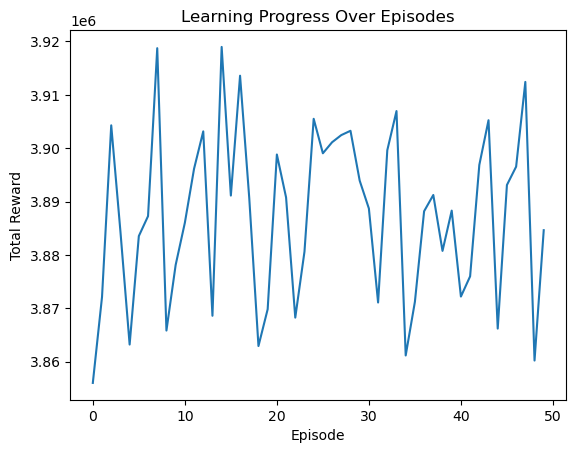

In [20]:
# Additional parameters
num_episodes = 50  # Number of days to simulate
learning_rewards = []  # To track the sum of rewards for each episode

for episode in range(num_episodes):
    total_episode_reward = 0  # Sum of rewards for the current episode
    
    # Reset battery level at the start of the episode
    battery_level = np.random.randint(0, num_battery_levels)  # Random initial battery level
    
    for hour in range(1, total_hours - 1):  # Ensure we have a next state
        price_level = price_bins[hour]  # Current price level
        state_index = get_state_index(battery_level, price_level)
        
        action = choose_action(state_index)  # Choose action based on the policy
        
        # Simplify reward calculation: reward for charging at low price, penalty for charging at high price
        reward = -prices[hour] if action == 0 else prices[hour] if action == 1 else 0
        total_episode_reward += reward
        
        # Update battery level based on action (simplified, without actual consumption or charging logic)
        battery_level = min(battery_level + 1, num_battery_levels - 1) if action == 0 else max(battery_level - 1, 0) if action == 1 else battery_level
        
        next_price_level = price_bins[hour + 1]
        next_state_index = get_state_index(battery_level, next_price_level)
        
        # Update Q-table
        update_q_table(state_index, action, reward, next_state_index)
    
    learning_rewards.append(total_episode_reward)

# Plot learning progress
plt.plot(learning_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Learning Progress Over Episodes')
plt.show()
